In [8]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

from datetime import datetime
import itertools
import argparse
import re
import os
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from rl_trader import MultiStockEnv, ReplayBuffer

In [2]:
def get_data():
  # 0 = AAPL
  # 1 = MSI
  # 2 = SBUX
  df = pd.read_csv('aapl_msi_sbux.csv')
  return df.values


def get_scaler(env):
  # return scikit-learn scaler object to scale the states
  # Note: you could also populate the replay buffer here

  states = []
  for _ in range(env.n_step):
    action = np.random.choice(env.action_space)
    state, reward, done, info = env.step(action)
    states.append(state)
    if done:
      break

  scaler = StandardScaler()
  scaler.fit(states)
  return scaler

In [3]:
def build_model(input_dim, n_action, n_hidden_layers=1, hidden_dim=32):
    """ A multi-layer perceptron """

    # input layer
    i = Input(shape=(input_dim,))
    x = i

    # hidden layers
    for _ in range(n_hidden_layers):
        x = Dense(hidden_dim, activation='relu')(x)

    # final layer
    x = Dense(n_action)(x)

    # make the model
    model = Model(i, x)

    model.compile(loss='mse', optimizer='adam')
    print((model.summary()))
    return model



In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(state_size, action_size, size=500)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = build_model(state_size, action_size)
    
    def update_replay_memory(self, state, action, reward, next_state, done):
        self.memory.store(state, action, reward, next_state, done)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    
    
    def replay(self, batch_size=32):
        # first check if replay buffer contains enough data
        if self.memory.size < batch_size:
            return

        # sample a batch of data from the replay memory
        minibatch = self.memory.sample_batch(batch_size)
        states = minibatch['s']
        actions = minibatch['a']
        rewards = minibatch['r']
        next_states = minibatch['s2']
        done = minibatch['d']

        # Calculate the tentative target: Q(s',a)
        target = rewards + (1 - done) * self.gamma * np.amax(self.model.predict(next_states), axis=1)

        # With the Keras API, the target (usually) must have the same
        # shape as the predictions.
        # However, we only need to update the network for the actions
        # which were actually taken.
        # We can accomplish this by setting the target to be equal to
        # the prediction for all values.
        # Then, only change the targets for the actions taken.
        # Q(s,a)
        target_full = self.model.predict(states)
        target_full[np.arange(batch_size), actions] = target

        # Run one training step
        self.model.train_on_batch(states, target_full)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [5]:
def play_one_episode(agent, env, is_train, scaler):
  # note: after transforming states are already 1xD
  state = env.reset()
  state = scaler.transform([state])
  done = False

  while not done:
    action = agent.act(state)
    next_state, reward, done, info = env.step(action)
    next_state = scaler.transform([next_state])
    if is_train == 'train':
      agent.update_replay_memory(state, action, reward, next_state, done)
      agent.replay(batch_size)
    state = next_state

  return info['cur_val']

In [10]:

# store the final value of the portfolio (end of episode)
portfolio_value = []

In [11]:
def main():
    NUM_EPISODE = 100
    IS_TRAIN = True
    
    data = get_data()
    n_timestamp, n_stocks = data.shape
    n_train = n_timestamp // 2  # divide and round

    train_data = data[:n_train]
    test_data = data[n_train:]   

    env = MultiStockEnv(get_data())
    env.reset()
    state_size = env.state_dim
    action_size = len(env.action_space)

    scaler = get_scaler(env)
    
    agent = DQNAgent(state_size, action_size)
    
    # play the game num_episodes times
    for e in range(NUM_EPISODE):
        t0 = datetime.now()
        val = play_one_episode(agent, env, IS_TRAIN, scaler)
        current_time = datetime.now() - t0
        print(f"episode: {e + 1}/{NUM_EPISODE}, episode end value: {val:.2f}, duration: {current_time}")
        portfolio_value.append(val) # append episode end portfolio value

main()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 27)                891       
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
_________________________________________________________________
None
episode: 1/100, episode end value: 43614.22, duration: 0:00:00.213434
episode: 2/100, episode end value: 40596.38, duration: 0:00:00.235994
episode: 3/100, episode end value: 33038.07, duration: 0:00:00.185081
episode: 4/100, episode end value: 22798.99, duration: 0:00:00.194020
episode: 5/100, episode end value: 28700.86, duration: 0:00:00.196503
episode: 6/100, episode end valu

(array([ 4., 11., 19., 24., 12., 12.,  7.,  4.,  5.,  2.]),
 array([14941.1472, 20737.1254, 26533.1036, 32329.0818, 38125.06  ,
        43921.0382, 49717.0164, 55512.9946, 61308.9728, 67104.951 ,
        72900.9292]),
 <a list of 10 Patch objects>)

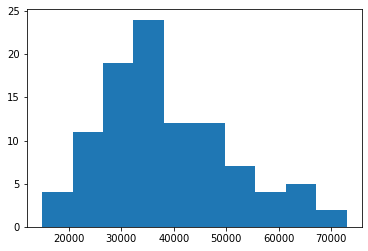

In [14]:
plt.hist(portfolio_value)
